In [ ]:
import pandas as pd 
import numpy as np 
import src.tools.download as download
from src import get_sequence_identities
from src.tools import MMSeqs, Prodigal
from src.dataset import Dataset
from src.files import FASTAFile, GBFFFile
from src.reference import Reference
from src.clusterer import Clusterer
from tqdm import tqdm
import os
import json 
from src.reference import compare
import seaborn as sns
from src import fillna 
import matplotlib.pyplot as plt
import matplotlib.ticker as tick 
from utils import * 

%load_ext autoreload
%autoreload 2

# Downloaded rare and model taxa on April 5, 2025. 

# Information on SwissProt manual curation: https://www.uniprot.org/help/manual_curation 

# TODO: There are partial sequences in the training dataset (at least in the spurious class). I am not sure if these are a good idea to
#   include, as there are no partial translations from Prodigal (except sometimes on the edges). How much does start codon value
#   affect the embedding?
# TODO: Should remind myself how I got all of the genome metadata. 


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [147]:
# is_bacterial = lambda df : np.array(['2' in lineage.split(' ') for lineage in df.lineage])

def filter_length(df:pd.DataFrame, max_length:int=2000, seq_col:str='seq'):
    mask = df[seq_col].apply(len) >= max_length
    print(f'filter_length: Removing {mask.sum()} sequences exceeding the maximum length of {max_length}.')
    df = df[~mask].copy()
    return df

def filter_suspect(df:pd.DataFrame):
    # Just checking if the product is "hypothetical protein" is sufficient for removing suspect sequences, as all non-annotated
    # sequences derived from ab initio predictions are assigned this exact label. However, there are homology-derived hypothetical
    # sequences which have different labels (e.g. "Uncharacterized protein")
    mask = (df['product'] == 'hypothetical protein') & (df.evidence_type == 'ab initio prediction')
    print(f'filter_length: Removing {mask.sum()} suspect sequences.')
    df = df[~mask].copy()
    return df

def filter_duplicates(df:pd.DataFrame, seq_col:str='seq'):
    # There are some duplicate IDs, as the same gene can be present in multiple genomes. Additionally, there are
    # some entries for identical sequences which do not have the same ID. This can mess up the bisecting k-means clustering, 
    # so I decided to remove these instances. 
    mask = df[seq_col].duplicated(keep='first')
    print(f'filter_duplicates: Removing {mask.sum()} duplicate sequences from the dataset')
    df = df[~mask].copy()
    return df 


In [209]:
swissprot_df = pd.read_csv('../data/swissprot.csv', index_col=0)
swissprot_df = swissprot_df[swissprot_df.domain == 'Bacteria'].copy()
swissprot_df = swissprot_df[~swissprot_df.index.duplicated()].copy() # Why are there so many duplicate entries in SwissProt?
FASTAFile(df=swissprot_df).write('../data/swissprot.faa')

In [214]:
dataset_df = pd.read_csv('../data/datasets/dataset.csv', index_col=0)
dataset_df[dataset_df.label == 1].phylum.nunique()

43

In [203]:
def build_dataset(swissprot_path:str='../data/swissprot.csv', antifam_path:str='../data/antifam_bacteria.csv'):
    dataset_df = pd.read_csv(swissprot_path, index_col=0)
    # dataset_df = dataset_df[dataset_df.domain.isin(['Bacteria', 'Viruses'])] # I am not completely confident about my decision to include viruses.
    dataset_df = dataset_df[dataset_df.domain == 'Bacteria'] # I am not completely confident about my decision to include viruses.

    antifam_df = pd.read_csv(antifam_path, index_col=0)
    antifam_df['ncbi_taxonomy_id'] = [int(lineage.split()[-1]) for lineage in antifam_df.lineage] # Get the species taxonomy ID from the full lineage. 

    dataset_df['library_entry_name'] = 'swissprot' 
    antifam_df['library_entry_name'] = 'antifam'

    dataset_df = pd.concat([antifam_df.assign(label=0), dataset_df.assign(label=1)])
    dataset_df = fillna(dataset_df, rules={str:'none', bool:False, int:0, float:0})

    dataset_df = filter_duplicates(dataset_df)
    dataset_df = filter_length(dataset_df)

    # For some reason, some of the taxonomy IDs map to different IDs in the NCBI database. 
    taxonomy_id_map = {369930:2576905, 1914757:1768011, 32059:477181, 2859001:2842348, 54064:334542}
    dataset_df['ncbi_taxonomy_id'] = dataset_df.ncbi_taxonomy_id.replace(taxonomy_id_map)

    print(f'build_dataset: Constructed a training dataset with {len(dataset_df)} sequences.')
    dataset_df.to_csv('../data/datasets/dataset.csv')

build_dataset()

filter_duplicates: Removing 138600 duplicate sequences from the dataset
filter_length: Removing 146 sequences exceeding the maximum length of 2000.
build_dataset: Constructed a training dataset with 278583 sequences.


In [204]:
dataset_df = pd.read_csv('../data/datasets/dataset.csv', index_col=0)
taxonomy_ids = dataset_df.ncbi_taxonomy_id.unique()

ncbi = download.NCBI()
taxonomy_metadata_df = ncbi.get_taxonomy_metadata(taxonomy_ids, path='../data/datasets/dataset_taxonomy_metadata.tsv')

NCBI._get_metadata: Found metadata entries for 8070 IDs already in ../data/datasets/dataset_taxonomy_metadata.tsv. Downloading metadata for 0 entries.


NCBI._get_metadata: Downloading metadata.: 0it [00:00, ?it/s]

NCBI.get_taxonomy_metadata: Writing metadata for 8070 taxa to ../data/datasets/dataset_taxonomy_metadata.tsv


In [205]:
def add_taxonomy_metadata(path:str='../data/datasets/dataset.csv'):
    taxonomy_metadata_df = pd.read_csv('../data/datasets/dataset_taxonomy_metadata.tsv', sep='\t', index_col=0)
    taxonomy_metadata_df['Domain name'] = 'Bacteria' # No domain column in downloaded data. 

    cols = [ 'Domain name', 'Phylum name', 'Class name', 'Order name', 'Family name', 'Genus name', 'Species name']

    taxonomy_metadata_df = taxonomy_metadata_df[cols]
    taxonomy_metadata_df = taxonomy_metadata_df.rename(columns={col:col.split()[0].lower() for col in cols})
    taxonomy_metadata_df = taxonomy_metadata_df.rename(columns={'kingdom':'domain'})
    taxonomy_metadata_df = fillna(taxonomy_metadata_df)

    dataset_df = pd.read_csv(path, index_col=0)
    dataset_df = dataset_df.drop(columns=taxonomy_metadata_df.columns, errors='ignore')
    dataset_df = dataset_df.merge(taxonomy_metadata_df, left_on='ncbi_taxonomy_id', right_index=True, how='left')
    dataset_df.to_csv(path)

add_taxonomy_metadata('../data/datasets/dataset.csv')
# add_taxonomy_metadata('../data/datasets/dataset_train.csv')
# add_taxonomy_metadata('../data/datasets/dataset_test.csv')


In [ ]:
# Want to try three different kinds of validation:
# (1) Model organisms, for which the annotated genomes will be the most reliable, and which have the most experimental support. 
# (2) Organisms from classes which are heavily-represented in the training data.
# (3) Organisms from classes which are not present in the training data. 
# For case (3), I want to be sure to not include exact species which are present in the traing data. 
# For all cases, I will limit myself to NCBI reference genomes. 

bacteria_dataset_df = dataset_df[dataset_df.domain == 'Bacteria'].copy()
genome_metadata_df = load_ncbi_genome_metadata() # Metadata for all available NCBI reference genomes. 

family_counts = bacteria_dataset_df.value_counts('family').sort_values(ascending=False)
family_counts = family_counts[family_counts.index.isin(genome_metadata_df.family.unique())]
common_families = family_counts.iloc[:10].index # Get the top ten most common families. 
rare_phyla = np.unique([phylum for phylum in genome_metadata_df.phylum if (phylum not in phylum_counts.index)]) # Phyla which are not present in the training data.

common_taxa = genome_metadata_df[genome_metadata_df.family.isin(common_families)].groupby('family').sample(5).index
rare_taxa = genome_metadata_df.index[genome_metadata_df.phylum.isin(rare_phyla)]
model_taxa = ['GCF_000005845.2', 'GCF_000009045.1','GCF_000006765.1', 'GCF_000195955.2']

genome_metadata_df.loc[rare_taxa].to_csv('../data/datasets/rare_taxa/rare_taxa_genome_metadata.csv')
genome_metadata_df.loc[common_taxa].to_csv('../data/datasets/common_taxa/common_taxa_genome_metadata.csv')
genome_metadata_df.loc[model_taxa].to_csv('../data/datasets/model_taxa/model_taxa_genome_metadata.csv')

In [ ]:
genome_ids = list(common_taxa) + list(rare_taxa) + list(model_taxa)

# ncbi = download.NCBI()
# ncbi.get_genomes(genome_ids=genome_ids, include=['gbff'], dirs={'gbff':'../data/ncbi/gbffs/', 'protein':'../data/ncbi/proteins/', 'genome':'../data/ncbi/genomes/'})
# ncbi.cleanup()

# prodigal = Prodigal()
# for genome_id in tqdm(genome_ids):
#     prodigal.run(f'../data/ncbi/genomes/{genome_id}_genomic.fna', f'../data/prodigal/{genome_id}_protein.faa')

# query_paths = [f'../data/prodigal/{genome_id}_protein.faa' for genome_id in genome_ids]
# reference_paths = [f'../data/ncbi/gbffs/{genome_id}_genomic.gbff' for genome_id in genome_ids]
# for query_path, reference_path in zip(query_paths, reference_paths):
#     compare(query_path, reference_path, overwrite=False)

In [160]:
dataset_df = pd.read_csv('../data/datasets/dataset.csv', index_col=0)

In [ ]:
def build_dataset_ncbi


,antifam_name,antifam_id,product,ncbi_taxonomy_id,organism,seq,lineage,library_entry_name,label,refseq_protein_id,...,name,kegg,file_name,domain,phylum,class,order,family,genus,species
id,,,,,,,,,,,,,,,,,,,,,
A0A0E3B620,Shadow ORF,ANF00001,Uncharacterized protein,280505,Leptospira borgpetersenii serovar Ballum,MGGGTVRETFLYQKIILFASKKLILVGILEKCVFLILPIPKPFSTC...,1 131567 2 203691 203692 1643688 170 171 174 ...,antifam,0,none,...,none,none,none,Bacteria,Spirochaetota,Spirochaetia,Leptospirales,Leptospiraceae,Leptospira,Leptospira borgpetersenii
A0A0F6IJP9,Shadow ORF,ANF00001,Uncharacterized protein,1193040,Leptospira interrogans str. FPW1039,MVFSEMERMKVKLYKYQIFNLSELLQSFVILSPALVWVGGEVVGKL...,1 131567 2 203691 203692 1643688 170 171 173 ...,antifam,0,none,...,none,none,none,Bacteria,Spirochaetota,Spirochaetia,Leptospirales,Leptospiraceae,Leptospira,Leptospira interrogans
A0A0M3TL24,Shadow ORF,ANF00001,Uncharacterized protein,1279460,Leptospira interrogans serovar Hardjo str. Norma,MQWLYQCEAKAQVVKIIILVGTLEKCAFLSLLILKSYSTSGLVMVE...,1 131567 2 203691 203692 1643688 170 171 173 ...,antifam,0,none,...,none,none,none,Bacteria,Spirochaetota,Spirochaetia,Leptospirales,Leptospiraceae,Leptospira,Leptospira interrogans
A0A0M3TMZ5,Shadow ORF,ANF00001,Mobile element protein,1279460,Leptospira interrogans serovar Hardjo str. Norma,MGGVVRFGKFFSIRKTYFLQIKRLILVGTLEKCAFLILLILKFY,1 131567 2 203691 203692 1643688 170 171 173 ...,antifam,0,none,...,none,none,none,Bacteria,Spirochaetota,Spirochaetia,Leptospirales,Leptospiraceae,Leptospira,Leptospira interrogans
A0A0M3TN01,Shadow ORF,ANF00001,Mobile element protein,1279460,Leptospira interrogans serovar Hardjo str. Norma,MLSFPYFWEGGGKFFSIRKTYFLQVKRLILVGTLEKCAFNPSHSKI...,1 131567 2 203691 203692 1643688 170 171 173 ...,antifam,0,none,...,none,none,none,Bacteria,Spirochaetota,Spirochaetia,Leptospirales,Leptospiraceae,Leptospira,Leptospira interrogans
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q8P8Z6,none,none,none,190485,none,MLEVSSHNVWTALAVTLAAGLATGLGSLMVVFAKKPNPRLLAFGLA...,Bacteria;Pseudomonadota;Gammaproteobacteria;Xa...,swissprot,1,NP_637447.1,...,ZUPT_XANCP,xcc:XCC2082,sprot.xml,Bacteria,Pseudomonadota,Gammaproteobacteria,Lysobacterales,Lysobacteraceae,Xanthomonas,Xanthomonas campestris
Q926D8,none,none,none,272626,none,MNKIIEVNNVSYHYDKEHALENIHFQVEKGSFTGLIGPNGSGKSTM...,Bacteria;Bacillota;Bacilli;Bacillales;Listeria...,swissprot,1,WP_003766893.1,...,ZURA_LISIN,lin:zurA,sprot.xml,Bacteria,Bacillota,Bacilli,Bacillales,Listeriaceae,Listeria,Listeria innocua
Q9XDA6,none,none,none,169963,none,MKKIIEVNNVSYHYDKEHALENIHFQVAKGSFTGLIGPNGSGKSTM...,Bacteria;Bacillota;Bacilli;Bacillales;Listeria...,swissprot,1,NP_464972.1,...,ZURA_LISMO,lmo:lmo1447,sprot.xml,Bacteria,Bacillota,Bacilli,Bacillales,Listeriaceae,Listeria,Listeria monocytogenes


In [76]:
def build_taxa_dataset(genome_ids:list, name='model_taxa'):
    pass 

In [83]:
dataset_df[dataset_df.domain == 'Bacteria'].phylum.nunique()

91

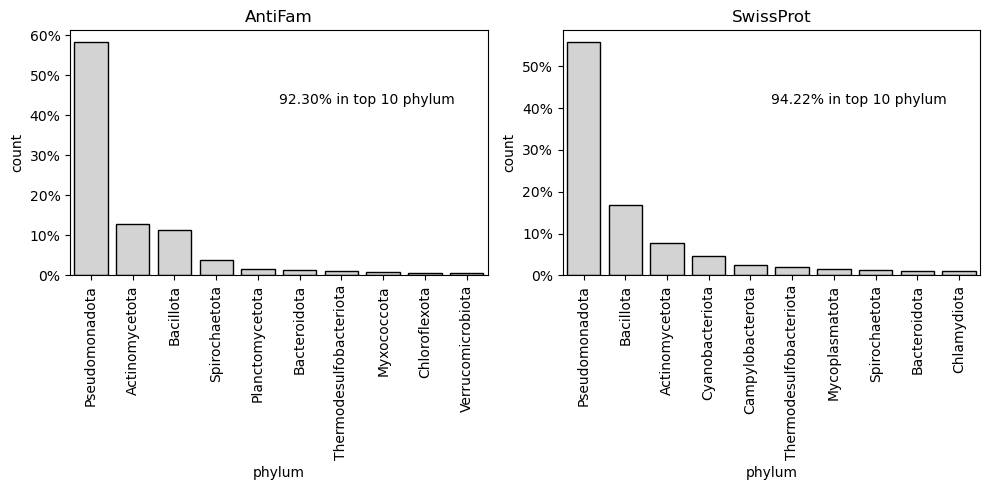

In [64]:
def figure(dataset_df:pd.DataFrame, level:str='genus', top_n:int=10):

    fig, axes = plt.subplots(ncols=2, figsize=(10, 5))

    for ax, (_, df) in zip(axes, dataset_df.groupby('label')):
        ax_df = df.copy()
        ax_df = ax_df.value_counts(level)
        ax_df = ax_df / ax_df.sum()
        ax_df = ax_df[ax_df.index != 'none'].copy()
        ax_df = ax_df.iloc[:top_n] * 100

        sns.barplot(data=ax_df, ax=ax, color='lightgray', edgecolor='black')

        if (level == 'species'):
            x_tick_labels = [f'{taxon.split()[0][0]}. {taxon.split()[-1]}' for taxon in ax_df.index]
            ax.set_xticks(np.arange(len(ax_df)), labels=x_tick_labels, rotation=90, fontstyle='italic')
        else:
            ax.set_xticks(np.arange(len(ax_df)), labels=ax_df.index, rotation=90)
        ax.yaxis.set_major_formatter(tick.PercentFormatter())
        ax.text(0.5, 0.7, f'{ax_df.sum():.2f}% in top {top_n} {level}', transform=ax.transAxes)

    axes[0].set_title('AntiFam')
    axes[1].set_title('SwissProt')

    fig.tight_layout()
    plt.show()

figure(bacteria_dataset_df, level='phylum')

In [2]:
# What is a good estimate for the number of clusters? Maybe use 50 percent sequence similarity?
# This resulted in about 70000 clusters for the Campylobacterota dataset. 
# This resulted in about 665000 clusters for the SwissProt dataset. 
# mmseqs = MMSeqs()
# mmseqs_cluster_df = mmseqs.cluster(dataset_df, name='dataset', output_dir='../data/datasets/swissprot', sequence_identity=0.5, overwrite=False)
# mmseqs.cleanup()
# print('Number of clusters:', mmseqs_cluster_df.mmseqs_cluster_id.nunique())

In [ ]:
dataset_df = pd.read_csv('../data/dataset_dereplicated.csv', index_col=0)
dataset_df = dataset_df.merge(pd.read_csv('../data/dataset_dereplicated_cluster.csv', index_col=0), left_index=True, right_index=True)

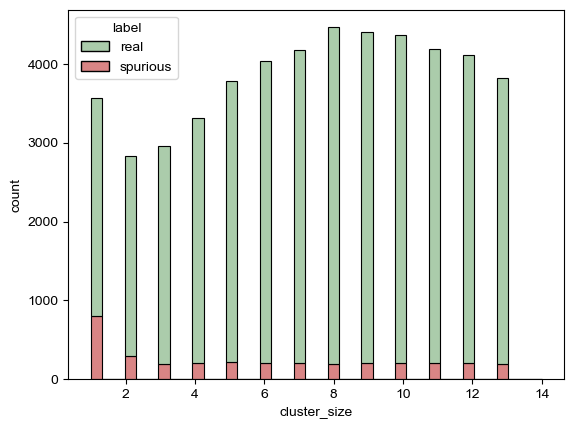

In [ ]:
fig, ax = plt.subplots()

ax_df = pd.DataFrame(index=dataset_df.cluster_label.unique())
ax_df['cluster_size'] = dataset_df.groupby('cluster_label').apply(len, include_groups=False)
ax_df['label'] = dataset_df.groupby('cluster_label').label.first()
ax_df['label'] = ax_df.label.replace({0:'spurious', 1:'real'})

palette = {'spurious':'indianred', 'real':'darkseagreen'}

sns.histplot(data=ax_df, x='cluster_size', hue='label', multiple='stack', ax=ax, palette=palette)
ax.set_ylabel('count')

plt.show()

In [ ]:
sequence_identities_df = list()
min_sequence_identity = 1

pbar = tqdm(list(dataset_df.groupby('cluster_label')), desc='Computing sequence identities.')
for cluster_label, df in pbar:
    values = get_sequence_identities(df, as_matrix=False)

    row = dict()
    row['cluster_label'] = cluster_label
    row['mean_sequence_identity'] = values.mean()
    row['min_sequence_identity'] = values.min()
    row['max_sequence_identity'] = values.max()
    row['standard_deviation'] = np.std(values)
    row['n_alignments'] = len(values)
    
    sequence_identities_df.append(row)

    if row['min_sequence_identity'] < min_sequence_identity:
        min_sequence_identity = row['min_sequence_identity']
        pbar.set_description(f'Computing sequence identities. Minimum identity {min_sequence_identity:.2f} found in cluster {cluster_label}.')

pbar.close()
sequence_identities_df = pd.DataFrame(sequence_identities_df).set_index('cluster_label')
sequence_identities_df.to_csv('dataset_dereplicated_cluster_sequence_identities.csv')

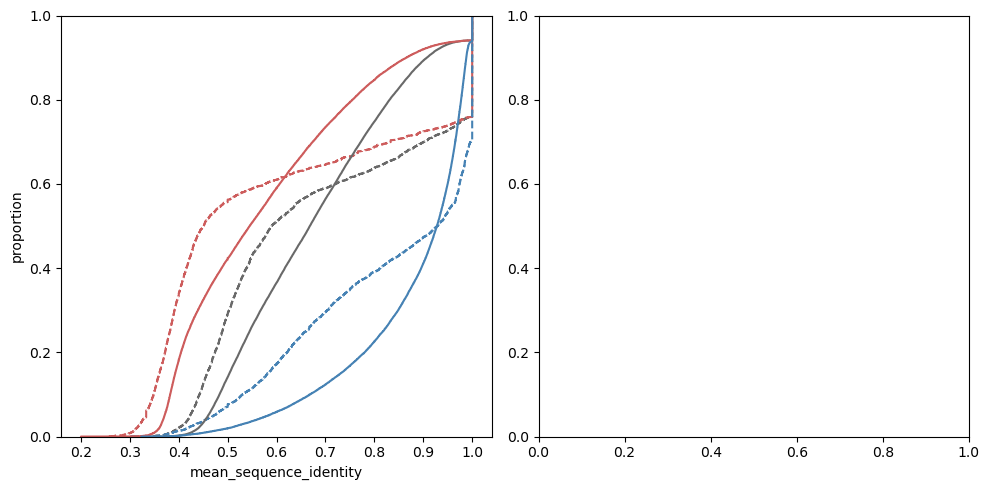

In [ ]:
sequence_identities_df = pd.read_csv('dataset_dereplicated_cluster_sequence_identities.csv', index_col=0)

fig, (ax_a, ax_b) = plt.subplots(ncols=2, figsize=(10, 5))

ax_a_df = sequence_identities_df.copy()
ax_a_df['label'] = dataset_df.groupby('cluster_label').label.first()
palette = {'spurious':'indianred', 'real':'darkseagreen'}

linestyles = {0:'--', 1:'-'}
for label, df in ax_a_df.groupby('label'):
    sns.ecdfplot(data=df, x='mean_sequence_identity', ax=ax_a, color='dimgray', label='mean sequence identity', linestyle=linestyles[label])
    sns.ecdfplot(data=df, x='min_sequence_identity', ax=ax_a, color='indianred', label='min. sequence identity', linestyle=linestyles[label])
    sns.ecdfplot(data=df, x='max_sequence_identity', ax=ax_a, color='steelblue', label='max. sequence identity', linestyle=linestyles[label])
ax_a.set_ylabel('proportion')

ax_b_df = pd.DataFrame(index=dataset_train_df.cluster_label.unique())

ax_b_df['cluster_size'] = ax_b_df.index.map(dataset_df.groupby('cluster_label').apply(len, include_groups=False))
# ax_b_df = ax_b_df.merge(sequence_identities_df, left_index=True, right_index=True)
# ax_b_df = ax_b_df.sort_values('min_sequence_identity').copy().iloc[:1000]

# sns.scatterplot(data=ax_b_df, x='min_sequence_identity', y='max_sequence_identity', ax=ax_b, color='dimgray')

fig.tight_layout()
plt.show()

In [ ]:

prodigal_df = list()
for genome_id in genome_ids:
    top_hits_df = Reference.load(f'../data/compare/{genome_id}_top_hits.csv')
    top_hits_df['genome_id'] = genome_id
    prodigal_df.append(top_hits_df)
prodigal_df = pd.concat(prodigal_df)
prodigal_df = filter_length(prodigal_df)


Removing 383 sequences which exceed the maximum length.
